# Proyecto ML

## Wikipedia Movie Plots

Importa las librarías que se usaran

In [24]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import re
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

np.warnings.filterwarnings('ignore')

from nltk import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

import tensorflow as tf
import tensorflow_hub as hub

tf.logging.set_verbosity(tf.logging.ERROR)

from tqdm import tqdm_notebook as tqdm

plt.style.use('ggplot')

Carga los datos (se pueden bajar de aquí: https://www.kaggle.com/jrobischon/wikipedia-movie-plots)

In [4]:
df = pd.read_csv("wiki_movie_plots_deduped.csv")
df.rename(columns={'Origin/Ethnicity':'Origin'}, inplace=True) # para mayor comodidad
df.shape

(34886, 8)

Muestra de los primeros datos

In [6]:
df.head(3)

,Release Year,Title,Origin,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."


### Descripción de las columnas

La base de datos contiene descripciones para 34,886 películas de todo el mundo. las columnas son las siguientes:

- Release Year - Año en que se estreno la película
- Title - Titulo de la película
- Origin/Ethnicity - Origen de la pelicula (e.g. America, Bollywood, Tamil, etc)
- Director - Director(s)
- Cast - Actores y actrices principales
- Genre - Genero(s) de la película
- Wiki Page - URL de la pagina de Wikipedia de la cual la descripción de la trama fue tomada
- Plot - descripción larga de la trama de la película (ADVERTENCIA: puede contener espoilers)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
Release Year    34886 non-null int64
Title           34886 non-null object
Origin          34886 non-null object
Director        34886 non-null object
Cast            33464 non-null object
Genre           34886 non-null object
Wiki Page       34886 non-null object
Plot            34886 non-null object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


In [8]:
df.describe()

,Release Year
count,34886.000000
mean,1981.314252
std,27.815174
min,1901.000000
25%,1957.000000
50%,1988.000000
75%,2007.000000
max,2017.000000


## Graficas

### Países de origen de las pelícuals

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

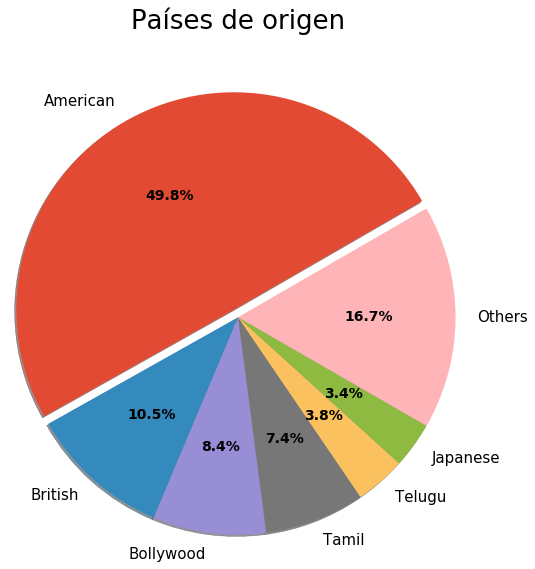

In [6]:
fig, ax = plt.subplots()
_, texts, autotexts = ax.pie(list(df['Origin'].value_counts()[:6].values) + [sum(df['Origin'].value_counts()[6:])], 
                    explode=(0.1, 0, 0, 0, 0, 0, 0), 
                    labels=list(df['Origin'].value_counts()[:6].index) + ["Others"], 
                    autopct='%1.1f%%',
                    shadow=True, radius=2.5, 
                    startangle=30)

ax.set_title('Países de origen', fontsize=26, loc="center",  y=1.8)
plt.setp(texts, size=15)
plt.setp(autotexts, size=14, weight="bold")

### Número de películas por año

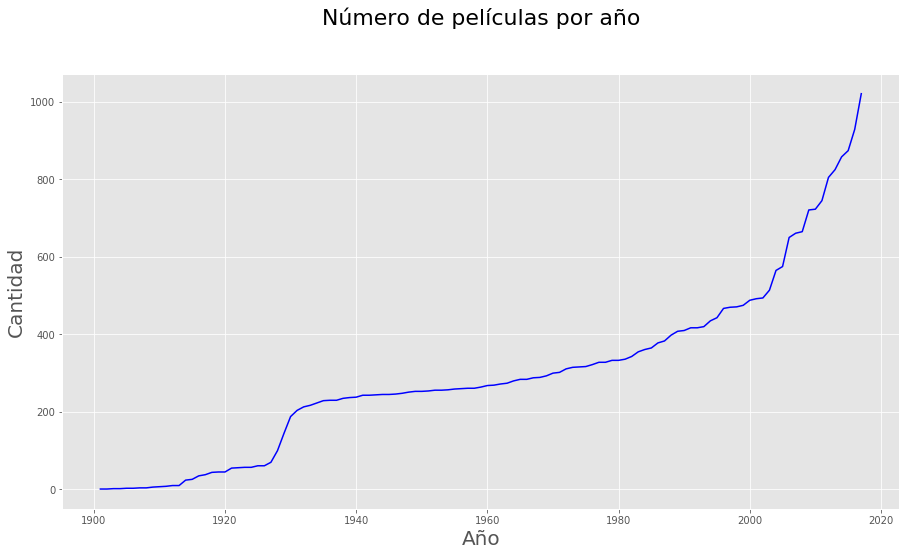

In [7]:
plt.figure(figsize=(15,8))
plt.title('Número de películas por año', fontsize=22, y=1.1)
plt.xlabel('Año', fontsize=20)
plt.ylabel('Cantidad', fontsize=20)
ax = plt.plot(df['Release Year'].unique()[::-1], df['Release Year'].value_counts(), 'b-')

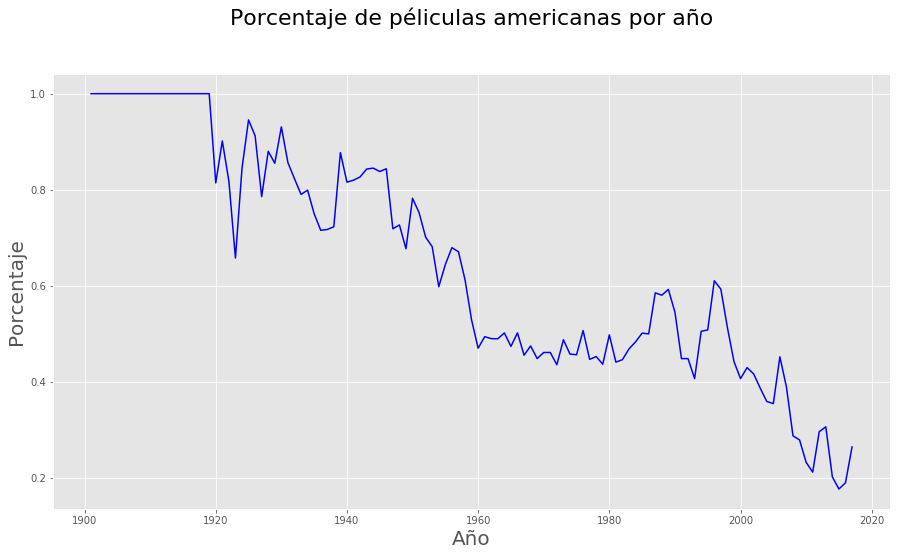

In [8]:
american_movies = df.query('Origin == "American"')['Release Year'].value_counts()
anywhere_movies = df['Release Year'].value_counts()

percentages = american_movies.divide(anywhere_movies)

plt.figure(figsize=(15,8))
plt.title('Porcentaje de péliculas americanas por año', fontsize=22, y=1.1)
plt.xlabel('Año', fontsize=20)
plt.ylabel('Porcentaje', fontsize=20)
ax = plt.plot(df['Release Year'].unique()[::-1], percentages[::-1], 'b-')

Géneros

In [9]:
len(df['Genre'].unique())

2265

Hay demasiados generos

### Reducción del numero de géneros

In [5]:
"""
This code is taken from:https://www.kaggle.com/aminejallouli/genre-classification-based-on-wiki-movies-plots
and it's a little bit modified.
"""
df['GenreCorrected'] =df['Genre'] 
df['GenreCorrected']=df['GenreCorrected'].str.strip()
df['GenreCorrected']=df['GenreCorrected'].str.replace(' - ', '|')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' / ', '|')
df['GenreCorrected']=df['GenreCorrected'].str.replace('/', '|')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' & ', '|')
df['GenreCorrected']=df['GenreCorrected'].str.replace(', ', '|')
df['GenreCorrected']=df['GenreCorrected'].str.replace('; ', '|')
df['GenreCorrected']=df['GenreCorrected'].str.replace('bio-pic', 'biography')
df['GenreCorrected']=df['GenreCorrected'].str.replace('biopic', 'biography')
df['GenreCorrected']=df['GenreCorrected'].str.replace('biographical', 'biography')
df['GenreCorrected']=df['GenreCorrected'].str.replace('biodrama', 'biography')
df['GenreCorrected']=df['GenreCorrected'].str.replace('bio-drama', 'biography')
df['GenreCorrected']=df['GenreCorrected'].str.replace('biographic', 'biography')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' \(film genre\)', '')
df['GenreCorrected']=df['GenreCorrected'].str.replace('animated','animation')
df['GenreCorrected']=df['GenreCorrected'].str.replace('anime','animation')
df['GenreCorrected']=df['GenreCorrected'].str.replace('children\'s','children')
df['GenreCorrected']=df['GenreCorrected'].str.replace('comedey','comedy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('\[not in citation given\]','')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' set 4,000 years ago in the canadian arctic','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('historical','history')
df['GenreCorrected']=df['GenreCorrected'].str.replace('romantic','romance')
df['GenreCorrected']=df['GenreCorrected'].str.replace('3-d','animation')
df['GenreCorrected']=df['GenreCorrected'].str.replace('3d','animation')
df['GenreCorrected']=df['GenreCorrected'].str.replace('viacom 18 motion pictures','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('sci-fi','science_fiction')
df['GenreCorrected']=df['GenreCorrected'].str.replace('ttriller','thriller')
df['GenreCorrected']=df['GenreCorrected'].str.replace('.','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('based on radio serial','')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' on the early years of hitler','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('sci fi','science_fiction')
df['GenreCorrected']=df['GenreCorrected'].str.replace('science fiction','science_fiction')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' (30min)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('16 mm film','short')
df['GenreCorrected']=df['GenreCorrected'].str.replace('\[140\]','drama')
df['GenreCorrected']=df['GenreCorrected'].str.replace('\[144\]','')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' for ','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('adventures','adventure')
df['GenreCorrected']=df['GenreCorrected'].str.replace('kung fu','martial_arts')
df['GenreCorrected']=df['GenreCorrected'].str.replace('kung-fu','martial_arts')
df['GenreCorrected']=df['GenreCorrected'].str.replace('martial arts','martial_arts')
df['GenreCorrected']=df['GenreCorrected'].str.replace('world war ii','war')
df['GenreCorrected']=df['GenreCorrected'].str.replace('world war i','war')
df['GenreCorrected']=df['GenreCorrected'].str.replace('biography about montreal canadiens star|maurice richard','biography')
df['GenreCorrected']=df['GenreCorrected'].str.replace('bholenath movies|cinekorn entertainment','')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' \(volleyball\)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('spy film','spy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('anthology film','anthology')
df['GenreCorrected']=df['GenreCorrected'].str.replace('biography fim','biography')
df['GenreCorrected']=df['GenreCorrected'].str.replace('avant-garde','avant_garde')
df['GenreCorrected']=df['GenreCorrected'].str.replace('biker film','biker')
df['GenreCorrected']=df['GenreCorrected'].str.replace('buddy cop','buddy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('buddy film','buddy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('comedy 2-reeler','comedy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('films','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('film','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('biography of pioneering american photographer eadweard muybridge','biography')
df['GenreCorrected']=df['GenreCorrected'].str.replace('british-german co-production','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('bruceploitation','martial_arts')
df['GenreCorrected']=df['GenreCorrected'].str.replace('comedy-drama adaptation of the mordecai richler novel','comedy-drama')
df['GenreCorrected']=df['GenreCorrected'].str.replace('movies by the mob\|knkspl','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('movies','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('movie','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('coming of age','coming_of_age')
df['GenreCorrected']=df['GenreCorrected'].str.replace('coming-of-age','coming_of_age')
df['GenreCorrected']=df['GenreCorrected'].str.replace('drama about child soldiers','drama')
df['GenreCorrected']=df['GenreCorrected'].str.replace('(( based).+)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('(( co-produced).+)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('(( adapted).+)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('(( about).+)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('musical b','musical')
df['GenreCorrected']=df['GenreCorrected'].str.replace('animationchildren','animation|children')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' period','period')
df['GenreCorrected']=df['GenreCorrected'].str.replace('drama loosely','drama')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' \(aquatics|swimming\)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' \(aquatics|swimming\)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace("yogesh dattatraya gosavi's directorial debut \[9\]",'')
df['GenreCorrected']=df['GenreCorrected'].str.replace("war-time","war")
df['GenreCorrected']=df['GenreCorrected'].str.replace("wartime","war")
df['GenreCorrected']=df['GenreCorrected'].str.replace("ww1","war")
df['GenreCorrected']=df['GenreCorrected'].str.replace('unknown','')
df['GenreCorrected']=df['GenreCorrected'].str.replace("wwii","war")
df['GenreCorrected']=df['GenreCorrected'].str.replace('psychological','psycho')
df['GenreCorrected']=df['GenreCorrected'].str.replace('rom-coms','romance')
df['GenreCorrected']=df['GenreCorrected'].str.replace('true crime','crime')
df['GenreCorrected']=df['GenreCorrected'].str.replace('\|007','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('slice of life','slice_of_life')
df['GenreCorrected']=df['GenreCorrected'].str.replace('computer animation','animation')
df['GenreCorrected']=df['GenreCorrected'].str.replace('gun fu','martial_arts')
df['GenreCorrected']=df['GenreCorrected'].str.replace('j-horror','horror')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' \(shogi|chess\)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('afghan war drama','war drama')
df['GenreCorrected']=df['GenreCorrected'].str.replace('\|6 separate stories','')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' \(30min\)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' (road bicycle racing)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' v-cinema','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('tv miniseries','tv_miniseries')
df['GenreCorrected']=df['GenreCorrected'].str.replace('\|docudrama','\|documentary|drama')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' in animation','|animation')
df['GenreCorrected']=df['GenreCorrected'].str.replace('((adaptation).+)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('((adaptated).+)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('((adapted).+)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('(( on ).+)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('american football','sports')
df['GenreCorrected']=df['GenreCorrected'].str.replace('dev\|nusrat jahan','sports')
df['GenreCorrected']=df['GenreCorrected'].str.replace('television miniseries','tv_miniseries')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' \(artistic\)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' \|direct-to-dvd','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('history dram','history drama')
df['GenreCorrected']=df['GenreCorrected'].str.replace('martial art','martial_arts')
df['GenreCorrected']=df['GenreCorrected'].str.replace('psycho thriller,','psycho thriller')
df['GenreCorrected']=df['GenreCorrected'].str.replace('\|1 girl\|3 suitors','')
df['GenreCorrected']=df['GenreCorrected'].str.replace(' \(road bicycle racing\)','')
filterE = df['GenreCorrected']=="ero"
df.loc[filterE,'GenreCorrected']="adult"
filterE = df['GenreCorrected']=="music"
df.loc[filterE,'GenreCorrected']="musical"
filterE = df['GenreCorrected']=="-"
df.loc[filterE,'GenreCorrected']=''
filterE = df['GenreCorrected']=="comedy–drama"
df.loc[filterE,'GenreCorrected'] = "comedy|drama"
filterE = df['GenreCorrected']=="comedy–horror"
df.loc[filterE,'GenreCorrected'] = "comedy|horror"
df['GenreCorrected']=df['GenreCorrected'].str.replace(' ','|')
df['GenreCorrected']=df['GenreCorrected'].str.replace(',','|')
df['GenreCorrected']=df['GenreCorrected'].str.replace('-','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('actionadventure','action|adventure')
df['GenreCorrected']=df['GenreCorrected'].str.replace('actioncomedy','action|comedy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('actiondrama','action|drama')
df['GenreCorrected']=df['GenreCorrected'].str.replace('actionlove','action|love')
df['GenreCorrected']=df['GenreCorrected'].str.replace('actionmasala','action|masala')
df['GenreCorrected']=df['GenreCorrected'].str.replace('actionchildren','action|children')

df['GenreCorrected']=df['GenreCorrected'].str.replace('fantasychildren\|','fantasy|children')
df['GenreCorrected']=df['GenreCorrected'].str.replace('fantasycomedy','fantasy|comedy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('fantasyperiod','fantasy|period')
df['GenreCorrected']=df['GenreCorrected'].str.replace('cbctv_miniseries','tv_miniseries')
df['GenreCorrected']=df['GenreCorrected'].str.replace('dramacomedy','drama|comedy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('dramacomedysocial','drama|comedy|social')
df['GenreCorrected']=df['GenreCorrected'].str.replace('dramathriller','drama|thriller')
df['GenreCorrected']=df['GenreCorrected'].str.replace('comedydrama','comedy|drama')
df['GenreCorrected']=df['GenreCorrected'].str.replace('dramathriller','drama|thriller')
df['GenreCorrected']=df['GenreCorrected'].str.replace('comedyhorror','comedy|horror')
df['GenreCorrected']=df['GenreCorrected'].str.replace('sciencefiction','science_fiction')
df['GenreCorrected']=df['GenreCorrected'].str.replace('adventurecomedy','adventure|comedy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('animationdrama','animation|drama')
df['GenreCorrected']=df['GenreCorrected'].str.replace('\|\|','|')
df['GenreCorrected']=df['GenreCorrected'].str.replace('muslim','religious')
df['GenreCorrected']=df['GenreCorrected'].str.replace('thriler','thriller')
df['GenreCorrected']=df['GenreCorrected'].str.replace('crimethriller','crime|thriller')
df['GenreCorrected']=df['GenreCorrected'].str.replace('fantay','fantasy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('actionthriller','action|thriller')
df['GenreCorrected']=df['GenreCorrected'].str.replace('comedysocial','comedy|social')
df['GenreCorrected']=df['GenreCorrected'].str.replace('martialarts','martial_arts')
df['GenreCorrected']=df['GenreCorrected'].str.replace('\|\(children\|poker\|karuta\)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('epichistory','epic|history')

df['GenreCorrected']=df['GenreCorrected'].str.replace('erotica','adult')
df['GenreCorrected']=df['GenreCorrected'].str.replace('erotic','adult')

df['GenreCorrected']=df['GenreCorrected'].str.replace('((\|produced\|).+)','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('chanbara','chambara')
df['GenreCorrected']=df['GenreCorrected'].str.replace('comedythriller','comedy|thriller')
df['GenreCorrected']=df['GenreCorrected'].str.replace('biblical','religious')
df['GenreCorrected']=df['GenreCorrected'].str.replace('biblical','religious')
df['GenreCorrected']=df['GenreCorrected'].str.replace('colour\|yellow\|productions\|eros\|international','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('\|directtodvd','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('liveaction','live|action')
df['GenreCorrected']=df['GenreCorrected'].str.replace('melodrama','drama')
df['GenreCorrected']=df['GenreCorrected'].str.replace('superheroes','superheroe')
df['GenreCorrected']=df['GenreCorrected'].str.replace('gangsterthriller','gangster|thriller')

df['GenreCorrected']=df['GenreCorrected'].str.replace('heistcomedy','comedy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('heist','action')
df['GenreCorrected']=df['GenreCorrected'].str.replace('historic','history')
df['GenreCorrected']=df['GenreCorrected'].str.replace('historydisaster','history|disaster')
df['GenreCorrected']=df['GenreCorrected'].str.replace('warcomedy','war|comedy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('westerncomedy','western|comedy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('ancientcostume','costume')
df['GenreCorrected']=df['GenreCorrected'].str.replace('computeranimation','animation')
df['GenreCorrected']=df['GenreCorrected'].str.replace('dramatic','drama')
df['GenreCorrected']=df['GenreCorrected'].str.replace('familya','family')
df['GenreCorrected']=df['GenreCorrected'].str.replace('familya','family')
df['GenreCorrected']=df['GenreCorrected'].str.replace('dramedy','drama|comedy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('dramaa','drama')
df['GenreCorrected']=df['GenreCorrected'].str.replace('famil\|','family')

df['GenreCorrected']=df['GenreCorrected'].str.replace('superheroe','superhero')
df['GenreCorrected']=df['GenreCorrected'].str.replace('biogtaphy','biography')
df['GenreCorrected']=df['GenreCorrected'].str.replace('devotionalbiography','devotional|biography')
df['GenreCorrected']=df['GenreCorrected'].str.replace('docufiction','documentary|fiction')

df['GenreCorrected']=df['GenreCorrected'].str.replace('familydrama','family|drama')

df['GenreCorrected']=df['GenreCorrected'].str.replace('espionage','spy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('supeheroes','superhero')
df['GenreCorrected']=df['GenreCorrected'].str.replace('romancefiction','romance|fiction')
df['GenreCorrected']=df['GenreCorrected'].str.replace('horrorthriller','horror|thriller')

df['GenreCorrected']=df['GenreCorrected'].str.replace('suspensethriller','suspense|thriller')
df['GenreCorrected']=df['GenreCorrected'].str.replace('musicaliography','musical|biography')
df['GenreCorrected']=df['GenreCorrected'].str.replace('triller','thriller')

df['GenreCorrected']=df['GenreCorrected'].str.replace('\|\(fiction\)','|fiction')

df['GenreCorrected']=df['GenreCorrected'].str.replace('romanceaction','romance|action')
df['GenreCorrected']=df['GenreCorrected'].str.replace('romancecomedy','romance|comedy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('romancehorror','romance|horror')

df['GenreCorrected']=df['GenreCorrected'].str.replace('romcom','romance|comedy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('rom\|com','romance|comedy')
df['GenreCorrected']=df['GenreCorrected'].str.replace('satirical','satire')

df['GenreCorrected']=df['GenreCorrected'].str.replace('science_fictionchildren','science_fiction|children')
df['GenreCorrected']=df['GenreCorrected'].str.replace('homosexual','adult')
df['GenreCorrected']=df['GenreCorrected'].str.replace('sexual','adult')

df['GenreCorrected']=df['GenreCorrected'].str.replace('mockumentary','documentary')
df['GenreCorrected']=df['GenreCorrected'].str.replace('periodic','period')
df['GenreCorrected']=df['GenreCorrected'].str.replace('romanctic','romantic')
df['GenreCorrected']=df['GenreCorrected'].str.replace('politics','political')
df['GenreCorrected']=df['GenreCorrected'].str.replace('samurai','martial_arts')
df['GenreCorrected']=df['GenreCorrected'].str.replace('tv_miniseries','series')
df['GenreCorrected']=df['GenreCorrected'].str.replace('serial','series')

filterE = df['GenreCorrected']=="musical–comedy"
df.loc[filterE,'GenreCorrected'] = "musical|comedy"

filterE = df['GenreCorrected']=="roman|porno"
df.loc[filterE,'GenreCorrected'] = "adult"


filterE = df['GenreCorrected']=="action—masala"
df.loc[filterE,'GenreCorrected'] = "action|masala"


filterE = df['GenreCorrected']=="horror–thriller"
df.loc[filterE,'GenreCorrected'] = "horror|thriller"

df['GenreCorrected']=df['GenreCorrected'].str.replace('family','children')
df['GenreCorrected']=df['GenreCorrected'].str.replace('martial_arts','action')
df['GenreCorrected']=df['GenreCorrected'].str.replace('horror','thriller')
df['GenreCorrected']=df['GenreCorrected'].str.replace('war','action')
df['GenreCorrected']=df['GenreCorrected'].str.replace('adventure','action')
df['GenreCorrected']=df['GenreCorrected'].str.replace('science_fiction','action')
df['GenreCorrected']=df['GenreCorrected'].str.replace('western','action')
df['GenreCorrected']=df['GenreCorrected'].str.replace('western','action')
df['GenreCorrected']=df['GenreCorrected'].str.replace('noir','black')
df['GenreCorrected']=df['GenreCorrected'].str.replace('spy','action')
df['GenreCorrected']=df['GenreCorrected'].str.replace('superhero','action')
df['GenreCorrected']=df['GenreCorrected'].str.replace('social','')
df['GenreCorrected']=df['GenreCorrected'].str.replace('suspense','action')


filterE = df['GenreCorrected']=="drama|romance|adult|children"
df.loc[filterE,'GenreCorrected'] = "drama|romance|adult"

df['GenreCorrected']=df['GenreCorrected'].str.replace('\|–\|','|')
df['GenreCorrected']=df['GenreCorrected'].str.strip(to_strip='\|')
df['GenreCorrected']=df['GenreCorrected'].str.replace('actionner','action')
df['GenreCorrected']=df['GenreCorrected'].str.strip()

def merge_similar(gn):
    gn_list = gn.split('|')
    gn_list.sort()
    return '|'.join(gn_list)

df['GenreCorrected']=df['GenreCorrected'].apply(merge_similar)
df['GenreCorrected']=df['GenreCorrected'].str.replace('^$','unknown')

print(df['GenreCorrected'].value_counts()[:50])

unknown                 6206
drama                   6107
comedy                  4411
action                  3790
thriller                2163
romance                  954
comedy|romance           689
comedy|drama             635
animation                601
crime                    573
crime|drama              572
musical                  471
drama|romance            397
action|drama             389
black                    345
mystery                  310
action|comedy            305
action|thriller          263
children                 256
comedy|musical           244
biography                229
fantasy                  204
action|action            163
comedy|thriller          154
children|drama           147
action|romance           123
biography|drama          115
comedy|crime             108
documentary              105
animation|short           97
drama|thriller            96
crime|thriller            90
history                   85
drama|history             76
series        

Text(0, 0.5, 'Número de ocurrencias')

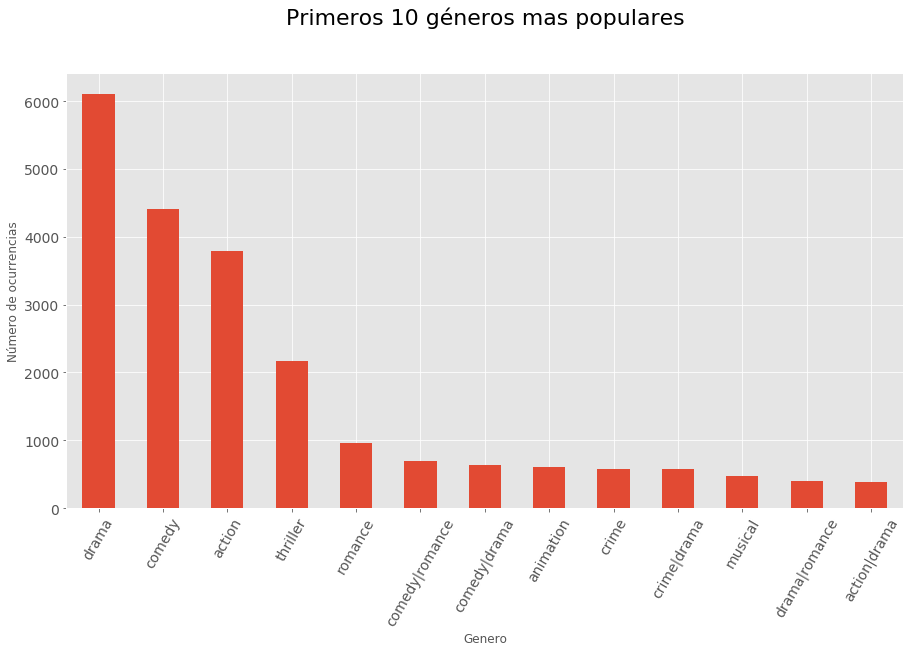

In [4]:
GenreCorrected = df.query('GenreCorrected != "unknown"')['GenreCorrected'].value_counts()
ax = GenreCorrected[:13].plot(kind='bar', figsize=(15,8), fontsize=14)
ax.set_title('Primeros 10 géneros mas populares', size=22, y=1.1)
plt.xticks(rotation=60)
plt.xlabel('Genero')
plt.ylabel('Número de ocurrencias')

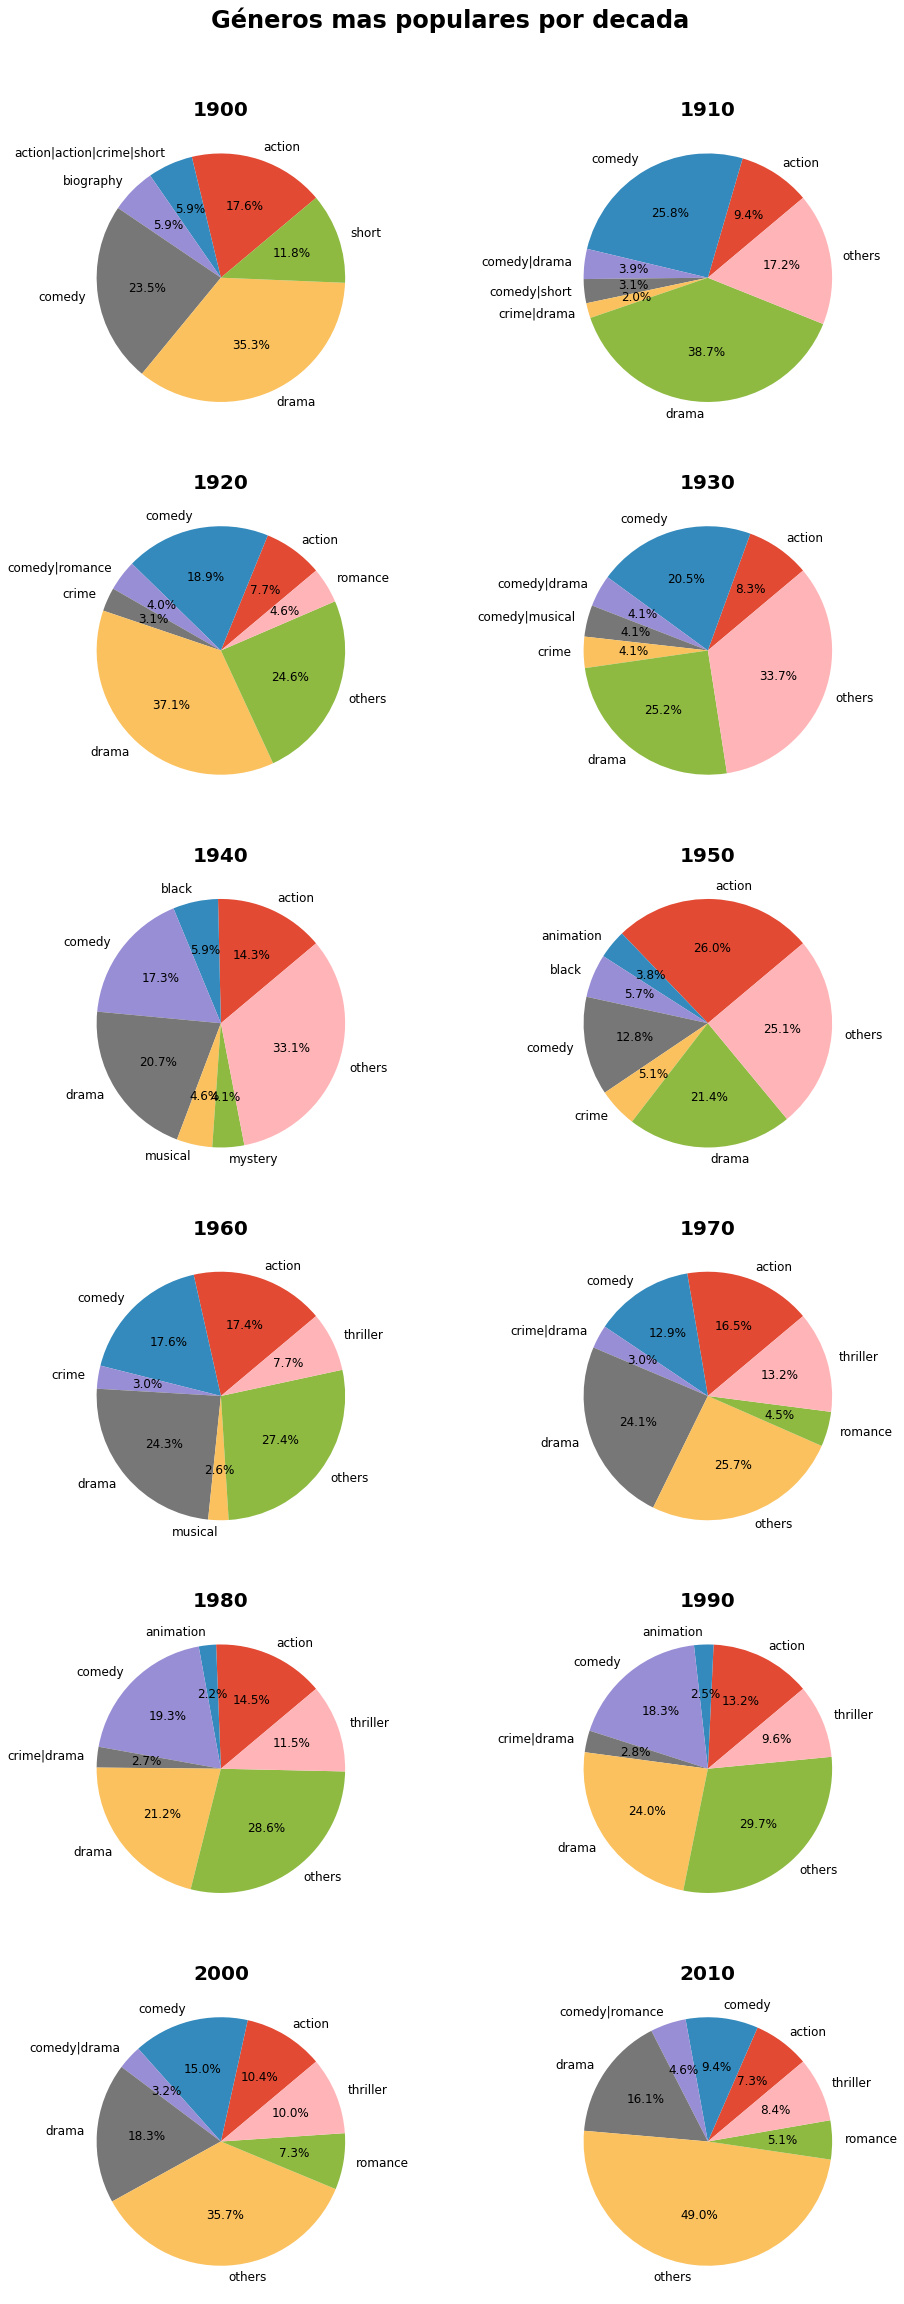

In [5]:
def grouping_func(s, index, splt_index):
    if list(s.index).index(index) > splt_index:
        return 'others'
    return index

fig, axes = plt.subplots(nrows=6, ncols=2)
fig.suptitle("Géneros mas populares por decada", fontsize=24, y=0.92, weight="bold")

for i, decade in enumerate(range(1900,2017,10)):
    populars = df.query(f'`Release Year` >= {decade} & `Release Year` < {decade+10} & GenreCorrected != "unknown"')['GenreCorrected'].value_counts()
    populars.groupby(lambda s: grouping_func(populars, s, 5)).sum().plot(ax=axes[i//2,i%2], 
                                                                         kind='pie', 
                                                                         fontsize=12, 
                                                                         autopct='%1.1f%%', 
                                                                         figsize=(16,40), 
                                                                         startangle=40, 
                                                                         label="")
    axes[i//2,i%2].set_title(f"{decade}", fontsize=20, weight="bold")

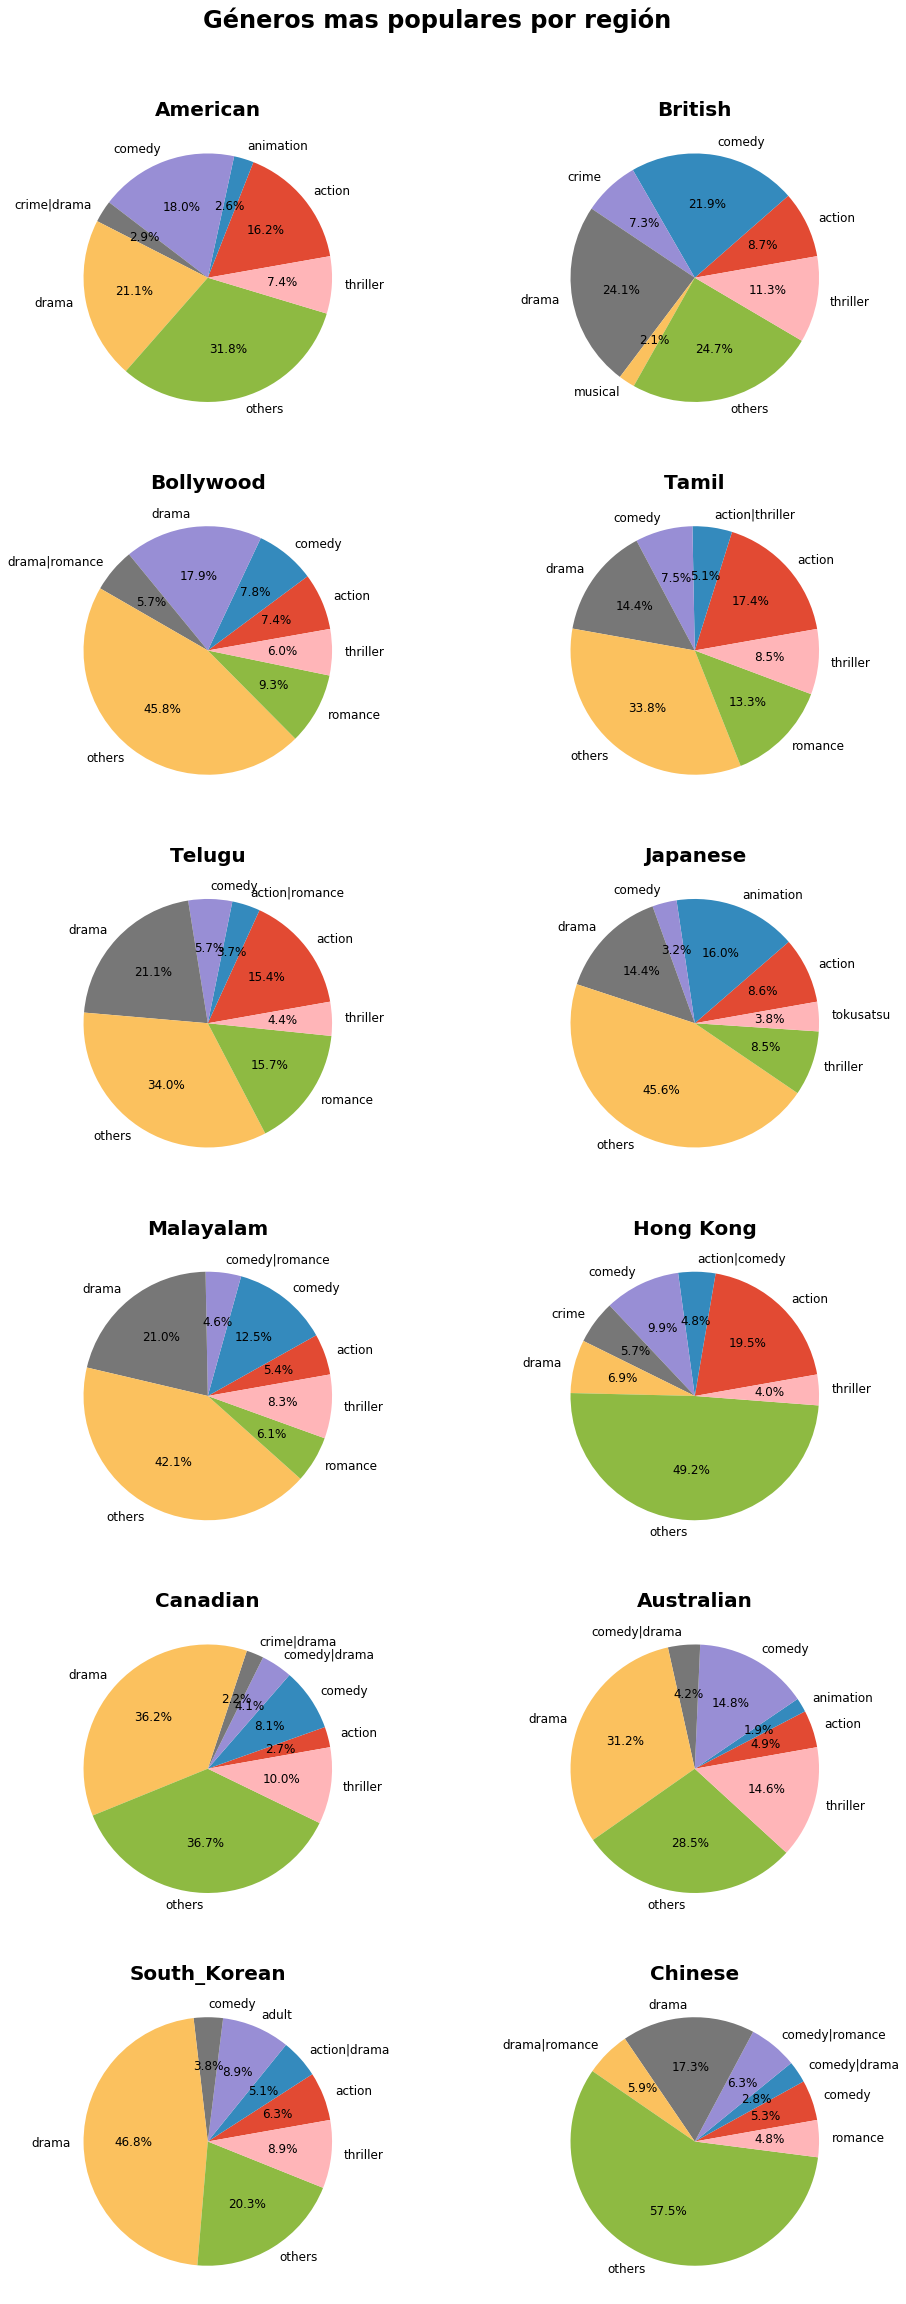

In [6]:
def grouping_func(s, index, splt_index):
    if list(s.index).index(index) > splt_index:
        return 'others'
    return index

fig, axes = plt.subplots(nrows=6, ncols=2)
fig.suptitle("Géneros mas populares por región", fontsize=24, y=0.92, weight="bold")

for i, origin in enumerate(df['Origin'].value_counts().head(12).index):
    populars = df.query(f'(Origin == "{origin}") & (GenreCorrected != "unknown")')['GenreCorrected'].value_counts()
    populars.groupby(lambda s: grouping_func(populars, s, 5)).sum().plot(ax=axes[i//2,i%2], kind='pie', 
                                                                         fontsize=12, autopct='%1.1f%%', 
                                                                         figsize=(16,40), startangle=10, 
                                                                         label="")
    axes[i//2,i%2].set_title(f"{origin}", fontsize=20, weight="bold")

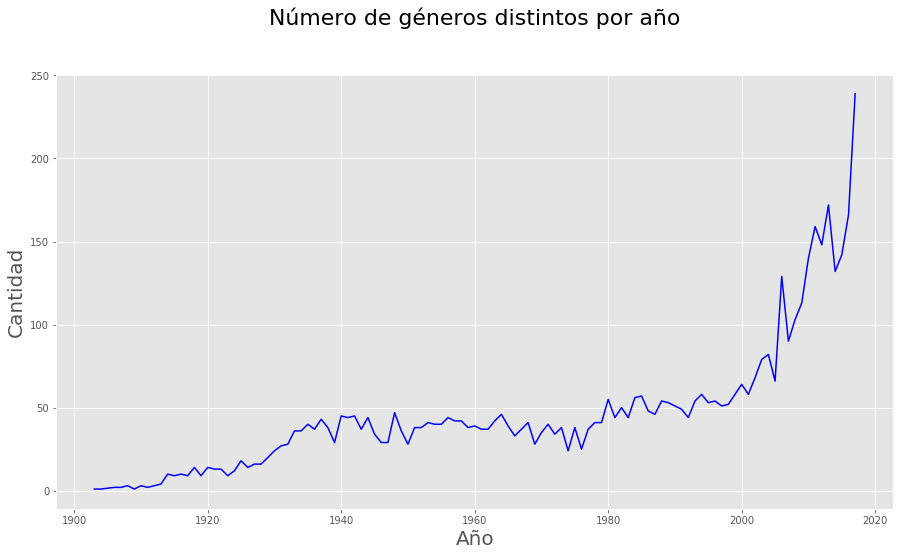

In [14]:
print()
plt.figure(figsize=(15,8))
plt.title('Número de géneros distintos por año', fontsize=22, y=1.1)
plt.xlabel('Año', fontsize=20)
plt.ylabel('Cantidad', fontsize=20)
genres_per_year = df.query('Genre != "unknown"').groupby('Release Year')['GenreCorrected'].nunique()
ax = plt.plot(genres_per_year.index,
              genres_per_year, 'b-')

### Algunos ejemplos de tramas

In [15]:
print(f'{df["Title"][342]} - {df["Release Year"][342]}')
print("")
print(df['Plot'][342])

Old Lady 31 - 1920

Based upon a summary of the plot in a review in a film publication,[3] Angie (Dunn) and Abe (Harmon) have been married for many years when bad investments force them to sell their homestead. Angie is to go to the old ladies' home while Abe is to go to live on the poor farm. When the twenty-nine inmates of the old ladies' home see how hard it is for the couple to part, they agree to take Abe in, and he is listed on their roster as "Old Lady 31." There are several comic situations as Abe wins his way into the hearts of his female companions. When some apparently worthless mining stock is found to have some value, the couple are able to return to their home.


In [16]:
print("{} - {}".format(df['Title'][7347],df['Release Year'][7347]))
print("")
print(df['Plot'][7347])

Five Guns to Tombstone - 1960

Young outlaw Billy Wade, determined to reform, is roped into a robbery by rich businessman George Landon, then framed for it. Billy's brother Matt is sprung from prison by Landon on the condition he get Billy to go along with the theft. During a struggle for a gun, Matt is accidentally killed and his teenaged son Ted and others mistakenly believe Billy killed him in cold blood. Billy pretends to help bandit Ike Garvey but ultimately assists in his capture, earning Ted's forgiveness.


In [17]:
print("{} - {}".format(df['Title'][5],df['Release Year'][5]))
print("")
print(df['Plot'][5])

Alice in Wonderland - 1903

Alice follows a large white rabbit down a "Rabbit-hole". She finds a tiny door. When she finds a bottle labeled "Drink me", she does, and shrinks, but not enough to pass through the door. She then eats something labeled "Eat me" and grows larger. She finds a fan when enables her to shrink enough to get into the "Garden" and try to get a "Dog" to play with her. She enters the "White Rabbit's tiny House," but suddenly resumes her normal size. In order to get out, she has to use the "magic fan."
She enters a kitchen, in which there is a cook and a woman holding a baby. She persuades the woman to give her the child and takes the infant outside after the cook starts throwing things around. The baby then turns into a pig and squirms out of her grip. "The Duchess's Cheshire Cat" appears and disappears a couple of times to Alice and directs her to the Mad Hatter's "Mad Tea-Party." After a while, she leaves.
The Queen invites Alice to join the "ROYAL PROCESSION": a p

### Formato de los textos

In [18]:
print("{} - {}".format(df['Title'][2454],df['Release Year'][2454]))
print("")
text = df['Plot'][2454]
text

The Sisters - 1938



"At a ball held on the night of the 1904 presidential election, serious Louise, frivolous Helen, and stolid Grace, daughters of Silver Bow, Montana pharmacist Ned Elliott and his wife Rose, find themselves dealing with romantic prospects. Tom Knivel is about to propose to Louise when Frank Medlin, a San Francisco sports reporter, asks her to dance. Infatuated with the young woman, Frank extends his stay, and at Sunday dinner in the Elliott home he announces he and Louise plan to wed. Although her parents disapprove of the union, Louise leaves for San Francisco with Frank that night. Grace eventually marries the jilted Tom and Helen weds wealthy Sam Johnson, who promises her freedom and asks for nothing in return.\r\nAlthough facing financial difficulty, Louise urges Frank to complete his novel. When she becomes pregnant, she decides to keep her condition a secret, but finally reveals the truth when she accompanies Frank to a boxing match and the smoke and smells make her ill. Returning

In [6]:
def clean_text(text):
    """
    This function is taken from:
    https://www.kaggle.com/aminejallouli/genre-classification-based-on-wiki-movies-plots
    """
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", "", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\[\d+\]", "", text)
    text = re.sub(r"[\(\)\"\r\[\]\{\}\\/¿\?\¡\!:,\.\'<>\d]", "", text)
    text = re.sub(r"[-\n]", " ", text)
    text = text.strip(' ')
    return text

# test
print(clean_text(df['Plot'][2454]))

at a ball held on the night of the  presidential election serious louise frivolous helen and stolid grace daughters of silver bow montana pharmacist ned elliott and his wife rose find themselves dealing with romantic prospects tom knivel is about to propose to louise when frank medlin a san francisco sports reporter asks her to dance infatuated with the young woman frank extends his stay and at sunday dinner in the elliott home he announces he and louise plan to wed although her parents disapprove of the union louise leaves for san francisco with frank that night grace eventually marries the jilted tom and helen weds wealthy sam johnson who promises her freedom and asks for nothing in return although facing financial difficulty louise urges frank to complete his novel when she becomes pregnant she decides to keep her condition a secret but finally reveals the truth when she accompanies frank to a boxing match and the smoke and smells make her ill returning home louise suffers a miscarr

In [7]:
df['FormattedPlot'] = df['Plot'].apply(clean_text)

### Nubes de palabras

Nube de palabras de las tramas en general

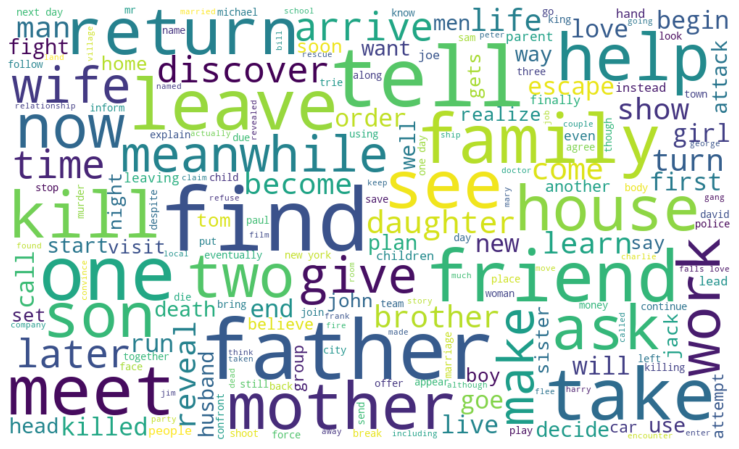

In [21]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, 
                      width=1000, 
                      height=600, 
                      max_font_size=120,
                      background_color="white").generate(" ".join(df.FormattedPlot))

plt.subplots(figsize=(18,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Nube de palabras de las tramas por genero

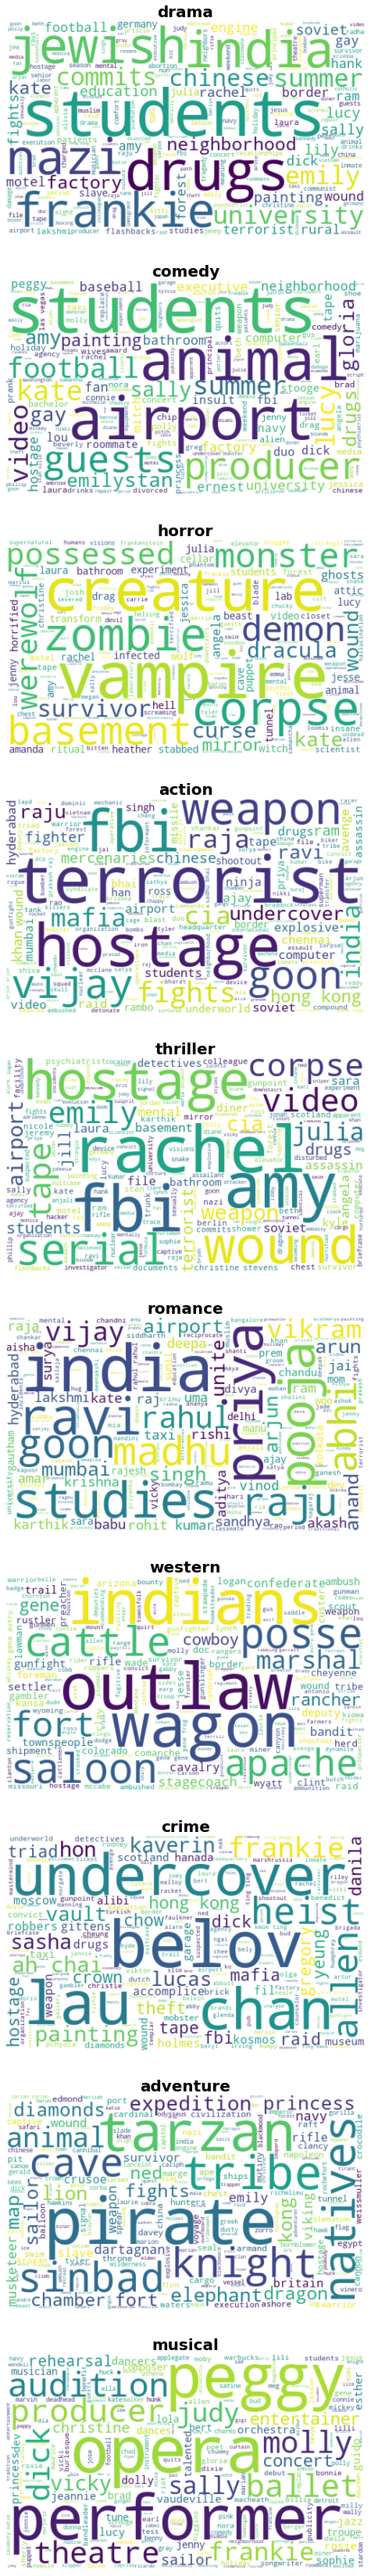

In [22]:
stopwords = set(STOPWORDS)
fig, axes = plt.subplots(nrows=10, ncols=1, figsize=(20,60))
#stopwords.update(['father', 'find', 'tell', 'meet', 'one', 'two', 'later', 'goes', 'take', 'finds', 'leave'])

frequent_words = dict()

for i, genre in enumerate(df['Genre'].value_counts()[1:11].index):
    words = list(set(word_tokenize(" ".join(df.query(f'Genre == "{genre}"')['FormattedPlot']))))
    for word in words:
        if word in frequent_words:
            frequent_words[word] += 1
        else:
            frequent_words[word] = 1
    
ordered_words = []
for key, value in frequent_words.items():
    ordered_words.append((value, key))
    
for word in ordered_words:
    if word[0] > 9:
        stopwords.add(word[1])

for i, genre in enumerate(df['Genre'].value_counts()[1:11].index):
    wordcloud = WordCloud(stopwords=stopwords,
                          width=500, 
                          height=300, 
                          max_font_size=90,
                          background_color="white").generate(" ".join(df.query(f'Genre == "{genre}"')['FormattedPlot']))
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title("{}".format(genre), fontsize=20, weight="bold")
    axes[i].axis('off')

## Entrenando un clasificador (la parte divertida)

In [16]:
data = df.query('GenreCorrected != "unknown"')
clases = list(data['Genre'].value_counts().head(20).index)

data = data[data['GenreCorrected'].isin(clases)]
data = data.reset_index()

X_train, X_test, y_train, y_test = train_test_split(list(data['FormattedPlot']), 
                                                    list(data['GenreCorrected']),
                                                    random_state=0)

stemmer = WordNetLemmatizer()
for i in range(len(X_train)):
    X_train[i] = [stemmer.lemmatize(word) for word in X_train[i].split(' ')]
    X_train[i] = ' '.join(X_train[i])
    
for i in range(len(X_test)):
    X_test[i] = [stemmer.lemmatize(word) for word in X_test[i].split(' ')]
    X_test[i] = ' '.join(X_test[i])
    
tfidf = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, stop_words='english')
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test).toarray()

In [17]:
clf = LinearSVC(random_state=0, max_iter=25000)
clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=25000,
          multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
          verbose=0)

In [18]:
y_pred = []
for i in range(len(y_test)):
    y_pred.append(clf.predict([X_test[i]])[0])

In [19]:
print(f'the accuracy is {np.mean(accuracy_score(y_pred, y_test))}')

the accuracy is 0.5971104231166151


## Sistema de recomendación de peliculas similares

In [13]:
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")

In [ ]:
embed_list = []
with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    for movie_plot in df['FormattedPlot']:
        encoded_sent = session.run(embed(sent_tokenize(movie_plot)))
        encoded_plot = encoded_sent.mean(axis=0).reshape(1,512)
        embed_list.append(encoded_plot)
df['EncodedPlot'] = embed_list